### Load data

In [1]:
import pubchempy as pcp
import requests
import json
import numpy as np
import pandas as pd
pd.set_option('display.max_rows',200,'display.max_columns',50)
import csv
import time
import pickle
from tqdm import tqdm
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import QED
from rdkit.Chem.Descriptors import MolWt
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir,'SA_Score'))
from sascorer import calculateScore

In [76]:
cols_required = ["PubChem CID", "PubChem SID", "BindingDB Ligand Name", "Ligand SMILES", "Ligand InChI", "UniProt (SwissProt) Primary ID of Target Chain", "Target Name", "UniProt (SwissProt) Entry Name of Target Chain", "BindingDB Target Chain Sequence", "PubChem AID", "Ki (nM)", "Kd (nM)", "IC50 (nM)", "EC50 (nM)"]

In [75]:
dict_to_convert_colnames = {"PubChem CID": "Compound_id",
                            "PubChem SID": "Compound_id2",
                            "BindingDB Ligand Name": "Compound_name",
                            "Ligand SMILES": "Compound_seq",
                            "Ligand InChI": "Compound_seq2",
                            "UniProt (SwissProt) Primary ID of Target Chain": "Target_id",
                            "Target Name": "Target_name",
                            "UniProt (SwissProt) Entry Name of Target Chain": "Target_name2",
                            "BindingDB Target Chain Sequence": "Target_seq",
                            "PubChem AID": "assay_id",
                            "Ki (nM)": "Ki",
                            "Kd (nM)": "Kd",
                            "IC50 (nM)": "IC50",
                            "EC50 (nM)": "EC50"
                           }

In [4]:
nrows = 100
rawdata = pd.read_csv("../data/BindingDB_All_202404.tsv", sep="\t", error_bad_lines=False, nrows=nrows)

In [8]:
list(rawdata.columns)

['BindingDB Reactant_set_id',
 'Ligand SMILES',
 'Ligand InChI',
 'Ligand InChI Key',
 'BindingDB MonomerID',
 'BindingDB Ligand Name',
 'Target Name',
 'Target Source Organism According to Curator or DataSource',
 'Ki (nM)',
 'IC50 (nM)',
 'Kd (nM)',
 'EC50 (nM)',
 'kon (M-1-s-1)',
 'koff (s-1)',
 'pH',
 'Temp (C)',
 'Curation/DataSource',
 'Article DOI',
 'BindingDB Entry DOI',
 'PMID',
 'PubChem AID',
 'Patent Number',
 'Authors',
 'Institution',
 'Link to Ligand in BindingDB',
 'Link to Target in BindingDB',
 'Link to Ligand-Target Pair in BindingDB',
 'Ligand HET ID in PDB',
 'PDB ID(s) for Ligand-Target Complex',
 'PubChem CID',
 'PubChem SID',
 'ChEBI ID of Ligand',
 'ChEMBL ID of Ligand',
 'DrugBank ID of Ligand',
 'IUPHAR_GRAC ID of Ligand',
 'KEGG ID of Ligand',
 'ZINC ID of Ligand',
 'Number of Protein Chains in Target (>1 implies a multichain complex)',
 'BindingDB Target Chain Sequence',
 'PDB ID(s) of Target Chain',
 'UniProt (SwissProt) Recommended Name of Target Chain',

In [13]:
rawdata.iloc[0]["Ligand SMILES"]

'O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=O)C(=O)N(CCCCCC(O)=O)[C@@H]1Cc1ccccc1'

In [12]:
rawdata.iloc[0]

BindingDB Reactant_set_id                                                                                               1
Ligand SMILES                                                           O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...
Ligand InChI                                                            InChI=1S/C31H42N2O7/c34-27(35)17-9-3-11-19-32-...
Ligand InChI Key                                                                              XGEGDSLAQZJGCW-HHGOQMMWSA-N
BindingDB MonomerID                                                                                                608734
BindingDB Ligand Name                                                   6-[(4R,5S,6S,7R)-4,7-dibenzyl-3-(5-carboxypent...
Target Name                                                                        Dimer of Gag-Pol polyprotein [501-599]
Target Source Organism According to Curator or DataSource                                  Human immunodeficiency virus 1
Ki (nM)                 

In [107]:
nrows = None
rawdata = pd.read_csv("../data/BindingDB_All_202404.tsv", sep="\t", usecols=cols_required, error_bad_lines=False, nrows=nrows)[cols_required].rename(columns=dict_to_convert_colnames)

/home2/glee/.conda/envs/drug2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8,9,10,11,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [108]:
rawdata

,Compound_id,Compound_id2,Compound_name,Compound_seq,Compound_seq2,Target_id,Target_name,Target_name2,Target_seq,assay_id,Ki,Kd,IC50,EC50
0,3009304.0,483500124.0,"6-[(4R,5S,6S,7R)-4,7-dibenzyl-3-(5-carboxypent...",O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...,InChI=1S/C31H42N2O7/c34-27(35)17-9-3-11-19-32-...,P03367,Dimer of Gag-Pol polyprotein [501-599],POL_HV1BR,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,aid1795214,0.24,NaN,NaN,NaN
1,5327236.0,8030010.0,"(4R,5S,6S,7R)-4,7-dibenzyl-5,6-dihydroxy-1,3-b...",O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,InChI=1S/C31H34N6O3/c38-29-27(17-23-9-3-1-4-10...,P03367,Dimer of Gag-Pol polyprotein [501-599],POL_HV1BR,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,aid1795214,0.25,NaN,NaN,NaN
2,5327235.0,8030008.0,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,InChI=1S/C29H34N4O3/c34-27-25(16-21-8-3-1-4-9-...,P03367,Dimer of Gag-Pol polyprotein [501-599],POL_HV1BR,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,aid1795214,0.41,NaN,NaN,NaN
3,5327234.0,8030007.0,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,InChI=1S/C29H40N2O4/c32-18-10-2-1-9-17-30-25(1...,P03367,Dimer of Gag-Pol polyprotein [501-599],POL_HV1BR,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,aid1795214,0.8,NaN,NaN,NaN
4,3009319.0,8030006.0,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,InChI=1S/C28H38N2O4/c31-17-9-3-8-16-29-24(18-2...,P03367,Dimer of Gag-Pol polyprotein [501-599],POL_HV1BR,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,aid1795214,0.99,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2844721,4829.0,318491292.0,Actos::CHEBI:8228::Duetact::Pioglitazone::US10...,CCc1ccc(CCOc2ccc(CC3SC(=O)NC3=O)cc2)nc1,InChI=1S/C19H20N2O3S/c1-2-13-3-6-15(20-12-13)9...,P37231,Peroxisome proliferator-activated receptor gamma,PPARG_HUMAN,MGETLGDSPIDPESDSFTDTLSANISQEMTMVDTEMPFWPTNFGIS...,NaN,NaN,NaN,NaN,6700
2844722,168298449.0,482618636.0,CHEMBL5219536,COc1cccc2ccc(c(O)c12)-c1cc(-c2ccc3cccc(OC)c3c2...,InChI=1S/C33H26O6/c1-37-25-10-4-7-18-13-15-21(...,Q03181,Peroxisome proliferator-activated receptor delta,PPARD_HUMAN,MEQPQEEAPEVREEEEKEEVAEAEGAPELNGGPQHALPSSSYTDLS...,NaN,NaN,NaN,NaN,53900
2844723,9803963.0,58097849.0,2-{2-methyl-4-[({4-methyl-2-[4-(trifluoromethy...,Cc1nc(sc1CSc1ccc(OCC(O)=O)c(C)c1)-c1ccc(cc1)C(...,InChI=1S/C21H18F3NO3S2/c1-12-9-16(7-8-17(12)28...,Q03181,Peroxisome proliferator-activated receptor delta,PPARD_HUMAN,MEQPQEEAPEVREEEEKEEVAEAEGAPELNGGPQHALPSSSYTDLS...,NaN,NaN,NaN,NaN,700
2844724,449171.0,85240518.0,9-cis retinoic acid::9C-RA::CHEMBL705::Panreti...,C\C(\C=C\C1=C(C)CCCC1(C)C)=C\C=C\C(\C)=C\C(O)=O,InChI=1S/C20H28O2/c1-15(8-6-9-16(2)14-19(21)22...,P19793,Retinoic acid receptor RXR-alpha,RXRA_HUMAN,MDTKHFLPLDFSTQVNSSLTSPTGRGSMAAPSLHPSLGPGIGSPGQ...,NaN,NaN,NaN,NaN,26


In [210]:
print("#Available data\n")
for curr_col in rawdata.columns:
    print("{}: {}".format(curr_col, np.round(len(rawdata[curr_col][rawdata[curr_col].notna()]) / len(rawdata), 4)))

#Available data

Compound_id: 0.9847
Compound_id2: 0.9848
Compound_name: 1.0
Compound_seq: 1.0
Compound_seq2: 0.9588
Target_id: 0.9702
Target_name: 1.0
Target_name2: 0.97
Target_seq: 1.0
assay_id: 0.407
Ki: 0.2056
Kd: 0.0378
IC50: 0.6659
EC50: 0.0917


In [211]:
len(rawdata["IC50"][rawdata["IC50"].notna()])

1894344

### Descriptive statistics 

[Total]


count    2.844726e+06
mean     6.080475e+01
std      4.147684e+01
min      1.000000e+00
25%      4.500000e+01
50%      5.500000e+01
75%      6.700000e+01
max      1.982000e+03
Name: Compound_seq, dtype: float64

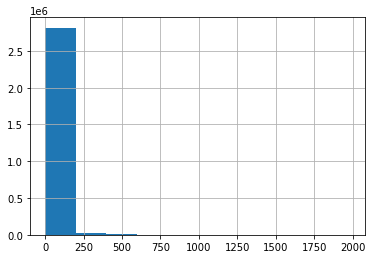

In [189]:
stats_compound_seq = rawdata["Compound_seq"].apply(lambda x: len(x))
print("[Total] Compound_seq")
display(stats_compound_seq.describe())
display(stats_compound_seq.hist())

[3/4 Quarter]


count    2.162336e+06
mean     4.917493e+01
std      1.126086e+01
min      1.000000e+00
25%      4.200000e+01
50%      5.000000e+01
75%      5.800000e+01
max      6.700000e+01
Name: Compound_seq, dtype: float64

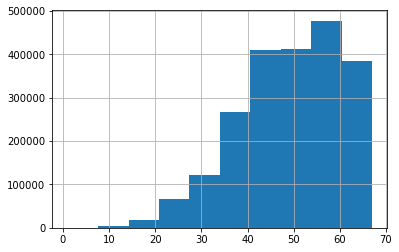

In [192]:
print("[3/4 Quarter] Compound_seq")
display(stats_compound_seq[stats_compound_seq<=stats_compound_seq.quantile(0.75)].describe())
display(stats_compound_seq[stats_compound_seq<=stats_compound_seq.quantile(0.75)].hist())

[Total]


count    2.844726e+06
mean     6.787042e+02
std      6.053412e+02
min      7.000000e+00
25%      3.800000e+02
50%      5.000000e+02
75%      8.090000e+02
max      7.182000e+03
Name: Target_seq, dtype: float64

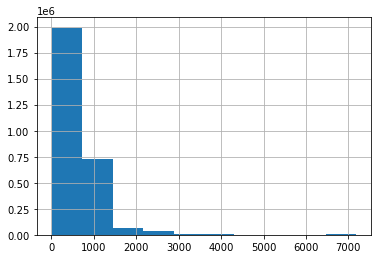

In [187]:
stats_target_seq = rawdata["Target_seq"].apply(lambda x: len(x))
print("[Total] Target_seq")
display(stats_target_seq.describe())
display(stats_target_seq.hist())

[3/4 Quarter]


count    2.135945e+06
mean     4.530341e+02
std      1.564652e+02
min      7.000000e+00
25%      3.520000e+02
50%      4.440000e+02
75%      5.450000e+02
max      8.090000e+02
Name: Target_seq, dtype: float64

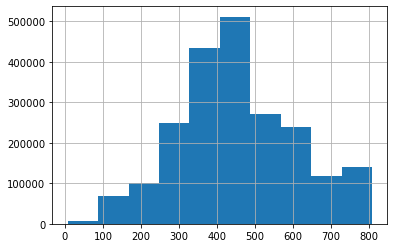

In [188]:
print("[3/4 Quarter] Target_seq")
display(stats_target_seq[stats_target_seq<=stats_target_seq.quantile(0.75)].describe())
display(stats_target_seq[stats_target_seq<=stats_target_seq.quantile(0.75)].hist())

[Total]


count    5.849490e+05
mean     3.422679e+08
std      1.849080e+11
min      0.000000e+00
25%      9.000000e+00
50%      1.020000e+02
75%      1.571000e+03
max      1.000000e+14
Name: Ki, dtype: float64

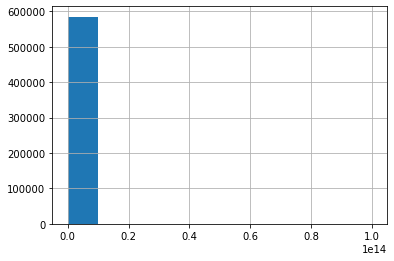

In [186]:
stats_Ki = rawdata["Ki"][rawdata["Ki"].notna()].apply(lambda x: x.replace(">","").replace("<","") if isinstance(x, str) else x).astype(np.float)
print("[Total] Ki")
display(stats_Ki.describe())
display(stats_Ki.hist())

[3/4 Quarter]


count    438721.000000
mean        193.160633
std         326.823350
min           0.000000
25%           4.300000
50%          33.000000
75%         213.000000
max        1571.000000
Name: Ki, dtype: float64

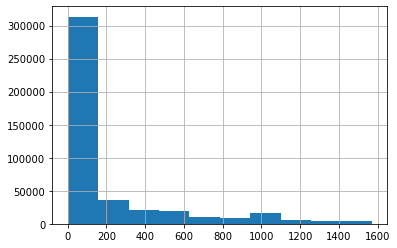

In [185]:
print("[3/4 Quarter] Ki")
display(stats_Ki[stats_Ki<=stats_Ki.quantile(0.75)].describe())
display(stats_Ki[stats_Ki<=stats_Ki.quantile(0.75)].hist())

[Total]


count    1.075580e+05
mean     2.308503e+05
std      1.360023e+07
min      0.000000e+00
25%      3.162000e+01
50%      1.700000e+03
75%      1.000000e+04
max      3.492000e+09
Name: Kd, dtype: float64

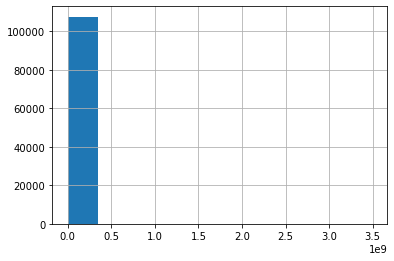

In [193]:
stats_Kd = rawdata["Kd"][rawdata["Kd"].notna()].apply(lambda x: x.replace(">","").replace("<","") if isinstance(x, str) else x).astype(np.float)
print("[Total] Kd")
display(stats_Kd.describe())
display(stats_Kd.hist())

[3/4 Quarter] Kd


count    98023.000000
mean      4042.398020
std       4563.206682
min          0.000000
25%         19.000000
50%        954.000000
75%      10000.000000
max      10000.000000
Name: Kd, dtype: float64

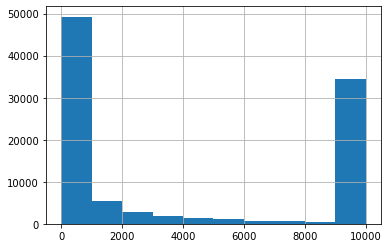

In [194]:
print("[3/4 Quarter] Kd")
display(stats_Kd[stats_Kd<=stats_Kd.quantile(0.75)].describe())
display(stats_Kd[stats_Kd<=stats_Kd.quantile(0.75)].hist())

[Total] IC50


count    1.894344e+06
mean     6.811557e+08
std      2.399644e+11
min      0.000000e+00
25%      2.890000e+01
50%      3.200000e+02
75%      5.500000e+03
max      1.000000e+14
Name: IC50, dtype: float64

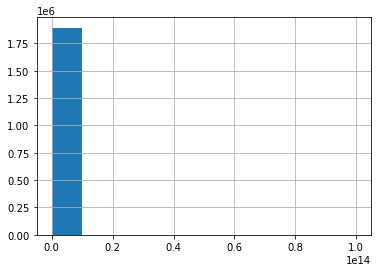

In [195]:
stats_IC50 = rawdata["IC50"][rawdata["IC50"].notna()].apply(lambda x: x.replace(">","").replace("<","") if isinstance(x, str) else x).astype(np.float)
print("[Total] IC50")
display(stats_IC50.describe())
display(stats_IC50.hist())

[3/4 Quarter] IC50


count    1.424755e+06
mean     6.320635e+02
std      1.178116e+03
min      0.000000e+00
25%      1.300000e+01
50%      1.000000e+02
75%      5.900000e+02
max      5.500000e+03
Name: IC50, dtype: float64

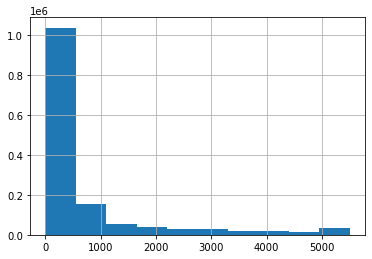

In [196]:
print("[3/4 Quarter] IC50")
display(stats_IC50[stats_IC50<=stats_IC50.quantile(0.75)].describe())
display(stats_IC50[stats_IC50<=stats_IC50.quantile(0.75)].hist())

[Total] EC50


count    2.607960e+05
mean     1.370409e+08
std      6.210754e+10
min      0.000000e+00
25%      3.700000e+01
50%      5.950000e+02
75%      1.000000e+04
max      3.162278e+13
Name: EC50, dtype: float64

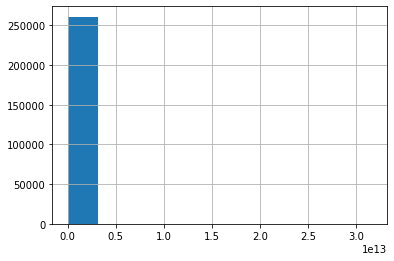

In [197]:
stats_EC50 = rawdata["EC50"][rawdata["EC50"].notna()].apply(lambda x: x.replace(">","").replace("<","") if isinstance(x, str) else x).astype(np.float)
print("[Total] EC50")
display(stats_EC50.describe())
display(stats_EC50.hist())

[3/4 Quarter] EC50


count    205353.000000
mean       1587.855604
std        2861.060138
min           0.000000
25%          17.200000
50%         193.000000
75%        1343.000000
max       10000.000000
Name: EC50, dtype: float64

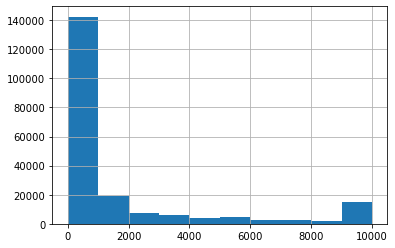

In [198]:
print("[3/4 Quarter] EC50")
display(stats_EC50[stats_EC50<=stats_EC50.quantile(0.75)].describe())
display(stats_EC50[stats_EC50<=stats_EC50.quantile(0.75)].hist())

### Preprocess

In [212]:
len_cond_C = 100
len_cond_T = 1000

In [249]:
bool_valid = rawdata.apply(lambda x: True if ((len(x["Compound_seq"]) <= len_cond_C) & (len(x["Target_seq"]) <= len_cond_T)) else False, axis=1)

In [259]:
valid_index = rawdata[(bool_valid & rawdata["Compound_id"].notna() & rawdata["Target_id"].notna() & rawdata["IC50"].notna())].index

In [261]:
cols_train = ["Compound_seq", "Target_seq", "IC50"]

In [266]:
data = rawdata.loc[valid_index, cols_train]

In [271]:
data["IC50"]

142         >50000
144         6676.9
180            8.5
181            177
183            164
            ...   
2844699      10810
2844700       2940
2844704    >100000
2844705    >100000
2844706       1960
Name: IC50, Length: 1337804, dtype: object

In [280]:
data[~data.apply(lambda x: isinstance(x["IC50"], str), axis=1)]

,Compound_seq,Target_seq,IC50
94208,OC(=O)CCCN1C(=S)S\C(=C/C=C/c2ccco2)C1=O,MFGLKRNAVIGLNLYCGGAGLGAGSGGATRPGGRLLATEKEASARR...,19324.8
94209,Oc1ccc(cc1)N1C(=S)S\C(=C/c2ccccn2)C1=O,MFGLKRNAVIGLNLYCGGAGLGAGSGGATRPGGRLLATEKEASARR...,5845.69
94210,COc1ccc2c(c1)oc1nc(-c3ccccc3)n(-c3ccc(C)cc3)c(...,MFGLKRNAVIGLNLYCGGAGLGAGSGGATRPGGRLLATEKEASARR...,54000
94211,Nc1ccc(N)c2c(O)c3ccccc3c(O)c12,MFGLKRNAVIGLNLYCGGAGLGAGSGGATRPGGRLLATEKEASARR...,1800.63
94212,Cc1c2cc(O)c(O)cc2oc2cc(=O)c(O)cc12,MFGLKRNAVIGLNLYCGGAGLGAGSGGATRPGGRLLATEKEASARR...,54000
...,...,...,...
174600,ON(Cc1ccc(O)cc1O)N=O,MSLIATVGPTGGVKNRLNIVDFVKNEKFFTLYVRSLELLQAKEQHD...,11600
174601,ON(Cc1cc(O)ccc1O)N=O,MSLIATVGPTGGVKNRLNIVDFVKNEKFFTLYVRSLELLQAKEQHD...,23800
174602,ON(Cc1ccc(Cl)cc1)N=O,MSLIATVGPTGGVKNRLNIVDFVKNEKFFTLYVRSLELLQAKEQHD...,13100
174603,COc1ccc(CN(O)N=O)cc1,MSLIATVGPTGGVKNRLNIVDFVKNEKFFTLYVRSLELLQAKEQHD...,9700


In [282]:
data.apply(lambda x: x["IC50"].replace(">","").replace("<","") if (("<" in str(x["IC50"])) | (">" in str(x["IC50"]))) else x["IC50"], axis=1)

142          50000
144         6676.9
180            8.5
181            177
183            164
            ...   
2844699      10810
2844700       2940
2844704     100000
2844705     100000
2844706       1960
Length: 1337804, dtype: object

In [296]:
# 부등호 제거
data.update(data["IC50"].apply(lambda x: x.replace(">","").replace("<","") if (("<" in str(x)) | (">" in str(x))) else x))
data["IC50"] = data["IC50"].astype(float)

In [306]:
data

,Compound_seq,Target_seq,IC50
142,Cc1nc(CN2CCN(CC2)c2c(Cl)cnc3[nH]c(nc23)-c2cn(C...,MALIPDLAMETWLLLAVSLVLLYLYGTHSHGLFKKLGIPGPTPLPF...,50000.0
144,O=C1CCCC2=C1C1(CCS(=O)(=O)C1)N=C(Nc1nc3ccccc3o...,MAALRQPQVAELLAEARRAFREEFGAEPELAVSAPGRVNLIGEHTD...,6676.9
180,CC(C)[C@H](NC(C)=O)C(=O)N[C@@H](Cc1ccccc1)[C@@...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,8.5
181,CCOC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1ccccc1)[...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,177.0
183,COCCOC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1ccccc1...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,164.0
...,...,...,...
2844699,OC[C@H]1O[C@@H](Oc2cc3C(=O)c4ccccc4C(=O)c3c(O)...,MEMEKEFEQIDKSGSWAAIYQDIRHEASDFPCRVAKLPKNKNRNRY...,10810.0
2844700,[O-][V]([O-])([O-])=O,MEMEKEFEQIDKSGSWAAIYQDIRHEASDFPCRVAKLPKNKNRNRY...,2940.0
2844704,OC[C@H]1O[C@@H](OCc2c(O)cc3C(=O)c4ccccc4C(=O)c...,MPTTIEREFEELDTQRRWQPLYLEIRNESHDYPHRVAKFPENRNRN...,100000.0
2844705,COc1ccc2C(=O)c3c(O)c(CO)c(O[C@@H]4O[C@H](CO)[C...,MPTTIEREFEELDTQRRWQPLYLEIRNESHDYPHRVAKFPENRNRN...,100000.0


In [307]:
data["Compound_seq"].unique().shape

(683032,)

In [308]:
data["Target_seq"].unique().shape

(4942,)

In [326]:
len(data.groupby(["Target_seq","Compound_seq"]).count().index) / len(data["Target_seq"].unique())

209.31950627276407

In [47]:
query = data.iloc[0]["Ligand SMILES"]

In [50]:
query = data.iloc[0]["Ligand SMILES"]
url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/fastsimilarity_2d/smiles/{}/cids/JSON?Threshold=95&MaxRecords=10".format(query)

In [52]:
res = requests.get(url)

In [54]:
d = json.loads(res.text)

In [56]:
d["IdentifierList"]

{'CID': [44623880, 44640149, 44640151]}

In [57]:
def get_cids(query, by="SMILES"):
    if by == "SMILES":
        url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/fastsimilarity_2d/smiles/{}/cids/JSON?Threshold=95&MaxRecords=10".format(query)
        res = requests.get(url)
        d = json.loads(res.text)
        return d["IdentifierList"]
    else:
        return None

In [58]:
get_cids(query)

{'CID': [44623880, 44640149, 44640151]}

In [61]:
cids = []
for i in tqdm(range(500)):
    query = data.iloc[i]["Ligand SMILES"]
    cids.append(get_cids(query))

 20%|█▉        | 99/500 [04:27<18:04,  2.71s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home2/glee/.conda/envs/drug2/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-61-410c0ef3ebe3>", line 4, in <module>
    cids.append(get_cids(query))
  File "<ipython-input-57-ee52f7239d67>", line 4, in get_cids
    res = requests.get(url)
  File "/home2/glee/.conda/envs/drug2/lib/python3.6/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home2/glee/.conda/envs/drug2/lib/python3.6/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home2/glee/.conda/envs/drug2/lib/python3.6/site-packages/requests/sessions.py", line 530, in request
    resp = self.send(prep, **send_kwargs)
  File "/home2/glee/.conda/envs/drug2/lib/python3.6/site-packages/requests/sessions.py", line 643, in send
    r = adapter.send(r

KeyboardInterrupt: 

In [62]:
cids[:10]

[{'CID': [44623880, 44640149, 44640151]},
 {'CID': [65023,
   461984,
   461965,
   461972,
   461966,
   461982,
   480069,
   44328419,
   44338669,
   44338692]},
 {'CID': [65023,
   461984,
   461965,
   461990,
   461969,
   461972,
   461976,
   461979,
   461983,
   461988]},
 {'CID': [461984,
   461965,
   461990,
   461969,
   461972,
   461976,
   461979,
   461983,
   461988,
   461982]},
 {'CID': [65023,
   461984,
   461965,
   461990,
   461969,
   461972,
   461976,
   461979,
   461983,
   461988]},
 {'CID': [461984,
   461965,
   461990,
   461969,
   461972,
   461976,
   461979,
   461983,
   461988,
   461982]},
 {'CID': [65023,
   461984,
   461965,
   461990,
   461969,
   461972,
   461976,
   461979,
   461983,
   461988]},
 {'CID': [461984,
   461965,
   461990,
   461969,
   461972,
   461976,
   461979,
   461983,
   461988,
   461982]},
 {'CID': [461984,
   461965,
   461990,
   461969,
   461972,
   461976,
   461979,
   461983,
   461988,
   461982]},
 {'C

In [42]:
def get_activity(cid):
    query = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/'+str(cid)+'/assaysummary/JSON'
    res = requests.get(query)
    d = json.loads(res.text)
    columns = np.array(d['Table']['Columns']['Column'])
    results = []
    target_dict = {}
    for i in range(len(d['Table']['Row'])):
        temp = list(d['Table']['Row'][i].values())[0]
        if 'Active' in temp and temp[8]!='' and temp[9]!='':
            results.append(temp)
            target_dict[temp[6]] = {}
    for i in results:
        #print(i[8],i[10],i[9])
        if i[8] in target_dict[i[6]].keys():
            target_dict[i[6]][i[8]].append(float(i[7]))
        else:
            target_dict[i[6]][i[8]] = []
            target_dict[i[6]][i[8]].append(float(i[7]))
    for i in results:
        target_dict[i[6]][i[8]] = np.mean(target_dict[i[6]][i[8]])
    ret = target_dict
    return ret

In [12]:
drugs = ['Allopurinol', 'Doxycycline', 'Lidocaine', 'Mazindol', 'Topiramate', 'Valproic acid', 'Zidovudine']
drug_cids = [135401907, 54671203, 3676, 4020, 5284627, 3121, 35370]

In [13]:
query = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/'+str(drug_cids[0])+'/assaysummary/JSON'
res = requests.get(query)
d = json.loads(res.text)
columns = np.array(d['Table']['Columns']['Column'])

In [14]:
columns

array(['AID', 'Panel Member ID', 'SID', 'CID', 'Activity Outcome',
       'Target GI', 'Target GeneID', 'Activity Value [uM]',
       'Activity Name', 'Assay Name', 'Assay Type', 'PubMed ID', 'RNAi'],
      dtype='<U19')

In [38]:
aaa = pd.DataFrame([cell["Cell"] for cell in d['Table']['Row']], columns = d['Table']['Columns']['Column']).set_index("AID")

In [42]:
aaa[aaa["Activity Outcome"]=="Active"]

,Panel Member ID,SID,CID,Activity Outcome,Target GI,Target GeneID,Activity Value [uM],Activity Name,Assay Name,Assay Type,PubMed ID,RNAi
AID,,,,,,,,,,,,
374,,8139898,135401907,Active,4758204,1843,,,In vitro Primary HTS Assay for MKP-1,Screening,,
1195,,48415533,135401907,Active,,,,,DSSTox (FDAMDD) FDA Maximum (Recommended) Dail...,Other,,
1822,,8139898,135401907,Active,23505220,813594,,,QFRET-based primary biochemical high throughpu...,Screening,,
1996,,56424020,135401907,Active,,,,,Aqueous Solubility from MLSMR Stock Solutions,Other,,
219599,,103533730,135401907,Active,109940048,280960,0.26,IC50,In vitro inhibitory concentration against Xant...,Confirmatory,11294382,
219739,,103533730,135401907,Active,2506326,7498,4.2,IC50,Inhibitory activity against Xanthine Oxidase,Confirmatory,8691450,
219741,,103533730,135401907,Active,2506326,7498,7,Ki,Inhibitory activity against Xanthine Oxidase,Confirmatory,8691450,
287937,,103533730,135401907,Active,2506326,7498,7.82,IC50,Inhibition of human xanthine oxidase,Confirmatory,17379526,
295041,,103533730,135401907,Active,2506326,7498,2.2,IC50,Inhibition of Xanthine oxidase,Confirmatory,17346963,


In [45]:
target_dict = {}
results = []
for i in range(len(d['Table']['Row'])):
    temp = list(d['Table']['Row'][i].values())[0]
    if 'Active' in temp and temp[8]!='' and temp[9]!='':
        results.append(temp)
        target_dict[temp[8]] = {}

In [49]:
results[0]

['219595',
 '',
 '103533730',
 '135401907',
 'Active',
 '2506326',
 '7498',
 '34.91',
 'IC50',
 'Inhibition of Xanthine oxidase',
 'Confirmatory',
 '12873513',
 '']

In [50]:
target_dict

{'IC50': {}, 'Ki': {}, 'Km': {}, 'Activity': {}, 'Potency': {}, 'Kd': {}}

In [51]:
activities = get_activity(drug_cids[2])

In [52]:
activities

{'': {'EC50': 0.017, 'Potency': 10.294966666666667},
 '6335': {'IC50': 29.0},
 '6329': {'IC50': 2.0},
 '6328': {'IC50': 10.5}}